In [119]:
import pandas as pd

data = pd.read_csv('/home/cakaltc1/Development/projects/application_files/experiments/ip_accounts_hiar_tfidf/generated_files/20171004/246_calculated_tfidf_for_term_value_matrix.csv')

In [120]:
from sklearn import preprocessing

accounts = data['AccountID']
del data['AccountID']

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data_n = data #pd.DataFrame(np_scaled)
data_n = data_n.astype('float32')

feature_size = len(data.columns)
print('Feature Size: ', feature_size)

#before applied scaling
print(data['stent_des_cathlab_27x'].head())
#after applied scaling
# print(data_n[299].head()) #->stent_des_cathlab_27x

Feature Size:  309
0    0.805482
1    0.805482
2    0.805482
3    0.805482
4    0.000000
Name: stent_des_cathlab_27x, dtype: float64


In [133]:
from keras.layers import Input, Dense
from keras.models import Model
import math

# this is the size of our encoded representations
encoding_dim = math.floor(feature_size * .8)  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats
print('Encoded dim:', encoding_dim)

# this is our input placeholder
input = Input(shape=(feature_size,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(feature_size, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs=input, outputs=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Just compute the distance before learning (show be very bad !)
import numpy as np
encoded = encoder.predict(data_n.values)
decoded = decoder.predict(encoded)
naivedist = np.zeros(len(data_n.values))
for i, x in enumerate(data_n.values):
    naivedist[i] = np.linalg.norm(x-decoded[i])
    
data['naivedist'] = naivedist

#learning 
autoencoder.fit(data_n.values, data_n.values,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)


Encoded dim: 247


In [134]:
#EVALUATION

encoded = encoder.predict(data_n.values)
decoded = decoder.predict(encoded)

In [135]:
import numpy as np

dist = np.zeros(len(data_n.values))
for i, x in enumerate(data_n.values):
    dist[i] = np.linalg.norm(x-decoded[i]) # euclidean distance

In [136]:
import matplotlib.pyplot as plt
def compute_error_per_dim(point):
    p = np.array(data_n.iloc[point,:]).reshape(1,feature_size)
    encoded = encoder.predict(p)
    decoded = decoder.predict(encoded)
    return np.array(p - decoded)[0]

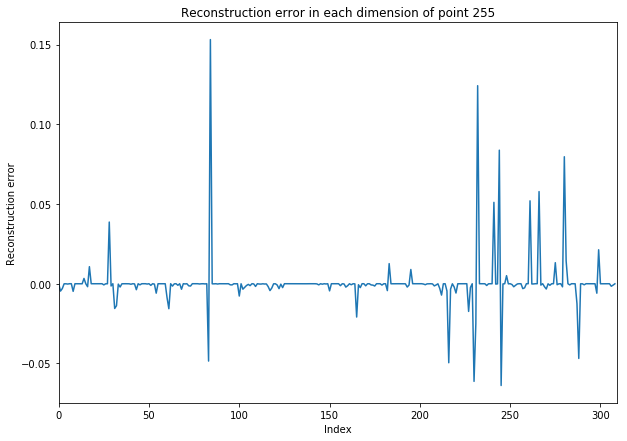

In [143]:
#print(compute_error_per_dim(1))

account_index = 255
plt.figure(figsize=(10,7))
plt.plot(compute_error_per_dim(account_index))
plt.xlim((0,feature_size))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point " + str(account_index))
plt.savefig("ae-outlier-reconstruction-"+str(account_index)+".svg", format="svg")
plt.show()


In [144]:
# Return a list of the dimensions with the highest reconstruction error
top10_features = np.argsort(compute_error_per_dim(account_index))[::-1][0:5]
print(top10_features)

[ 84 232 244 280 266]


In [68]:
data.columns[280]
#data.columns[241]

'introducer_sheath_guiding_cathlab_27x'